# 1) Introduction and Background

Here, I've analyzed the US Accidents dataset from Kaggle. I want to study where and when accidents happen, and be able to characterize the accidents on a large set of criteria, including location, time, and other factors. I ultimately decided to try and predict the duration of the accident, given a variety of factors, including the severity, the location, precipitation, and others.


In [ ]:
!pip install PyDrive
!pip install geopandas

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google_drive_downloader import GoogleDriveDownloader as gdd

In [ ]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT, force_remount=True)

# create folder to write data to
CIS545_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS545_2020')
HOMEWORK_FOLDER=os.path.join(CIS545_FOLDER, 'HW5')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/My Drive/us-accidents.zip"
!unzip '/content/gdrive/My Drive/states_21basic.zip'

Archive:  /content/gdrive/My Drive/us-accidents.zip
replace US_Accidents_Dec19.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/gdrive/My Drive/states_21basic.zip
replace states.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# 2) Exploratory Data Analysis

In [ ]:
# reading in the file to pandas, where I can manipulate it!
import pandas as pd
accidents_df = pd.read_csv('US_Accidents_Dec19.csv')

In [ ]:
accidents_df

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.010,Right lane blocked due to accident on I-70 Eas...,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.010,Accident on Brice Rd at Tussing Rd. Expect del...,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.010,Accident on OH-32 State Route 32 Westbound at ...,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.010,Accident on I-75 Southbound at Exits 52 52B US...,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.010,Accident on McEwen Rd at OH-725 Miamisburg Cen...,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2974330,A-2974354,Bing,NaN,2,2019-08-23 18:03:25,2019-08-23 18:32:01,34.002480,-117.379360,33.99888,-117.37094,0.543,At Market St - Accident.,NaN,Pomona Fwy E,R,Riverside,Riverside,CA,92501,US,US/Pacific,KRAL,2019-08-23 17:53:00,86.0,86.0,40.0,28.92,10.0,W,13.0,0.00,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
2974331,A-2974355,Bing,NaN,2,2019-08-23 19:11:30,2019-08-23 19:38:23,32.766960,-117.148060,32.76555,-117.15363,0.338,At Camino Del Rio/Mission Center Rd - Accident.,NaN,I-8 W,R,San Diego,San Diego,CA,92108,US,US/Pacific,KMYF,2019-08-23 18:53:00,70.0,70.0,73.0,29.39,10.0,SW,6.0,0.00,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day
2974332,A-2974356,Bing,NaN,2,2019-08-23 19:00:21,2019-08-23 19:28:49,33.775450,-117.847790,33.77740,-117.85727,0.561,At Glassell St/Grand Ave - Accident. in the ri...,NaN,Garden Grove Fwy,R,Orange,Orange,CA,92866,US,US/Pacific,KSNA,2019-08-23 18:53:00,73.0,73.0,64.0,29.74,10.0,SSW,10.0,0.00,Partly Cloudy,False,False,False,False,True,False,False,False,False,False,False,False,False,Day,Day,Day,Day
2974333,A-2974357,Bing,NaN,2,2019-08-23 19:00:21,2019-08-23 19:29:42,33.992460,-118.403020,33.98311,-118.39565,0.772,At CA-90/Marina Fwy/Jefferson Blvd - Accident.,NaN,San Diego Fwy S,R,Culver City,Los Angeles

**Data Visualization and Exploration** - Here, I visualize the data in a variety of ways.

In [ ]:
#import the good stuff. seaborn is really pretty
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt

<BarContainer object of 4 artists>

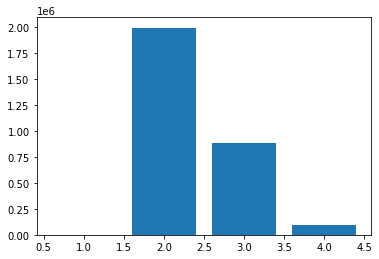

In [ ]:
# What is the distribution of severity? Let's just put a simple bar plot to see 
# even or uneven the data is.
num_accidents1,_ = accidents_df[accidents_df['Severity'] == 1].shape
num_accidents2,_ = accidents_df[accidents_df['Severity'] == 2].shape
num_accidents3,_ = accidents_df[accidents_df['Severity'] == 3].shape
num_accidents4,_ = accidents_df[accidents_df['Severity'] == 4].shape

distr = [num_accidents1, num_accidents2, num_accidents3, num_accidents4]
plt.bar(x=[1,2,3,4], height=distr)

Ok, so the distribution by severity is really uneven. There are millions of data points with a severity of 2, but only hundreds for severity 1. Let's be sure to be careful if we are trying to predict the severity, since the model is not learning from a uniform distribution.

**Distribution of Accidents By Start Hour** - Let's look at how the accidents are distributed by time using a violin plot! They're like box and whisker plots, but better.

In [ ]:
#Extract the start hour for each accident
# example string: 2016-02-08 05:46:00
import datetime
accidents_df['Start_Time'] = accidents_df['Start_Time'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
accidents_df['start_hour'] = accidents_df['Start_Time'].apply(lambda x: x.hour)
accidents_df['start_month'] = accidents_df['Start_Time'].apply(lambda x: x.month)

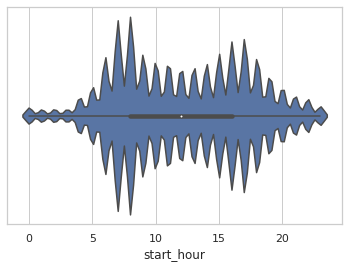

In [ ]:
#Violin Plot of Accident by Hour of Day
sns.violinplot(x='start_hour', data=accidents_df, scale, gridsize=10000)

Here, we see a bimodal distribution. There are clear peaks around 7-9 am, and 4-5 pm. These seem to be the daily rush hours! The morning commute literally kills. Now, let's look at this distribution by severity.

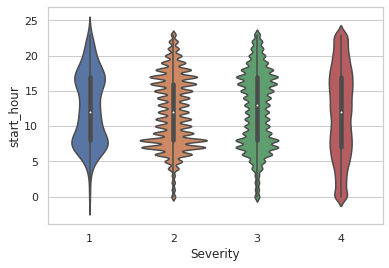

In [ ]:
# the larger the grid size, the more accurate the density 
sns.violinplot(x='Severity', y='start_hour', data=accidents_df, split=True, gridsize=900)

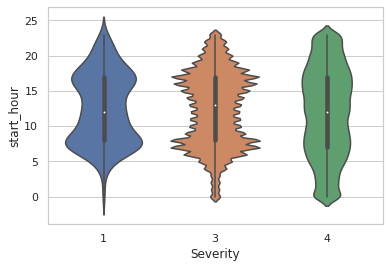

In [ ]:
sns.violinplot(x='Severity', y='start_hour', data=accidents_df[accidents_df['Severity'] != 2], split=True)

1 and 4 look a lot smoother, which is weird but could result from the sources (like MapQuest) only reporting accidents at regular intervals. For example, if acccidents were only reported every hour, then you would see 24 spikes. If you painstakingly count the little spikes on the orange 3 violin plot, there are indeed 24 spikes. There could be other reasons for this, but this seems the most likely.

All of the severities except for 4 have the same bimodal peaks during morning and evening commutes. However, severity 4 accidents are a lot smoother, suggesting that they happen more uniformly throughout the day, and that severe accidents have less to do with the time of day.

**Geographic Locations of Accidents**

In [ ]:
#Display all accidents on a map
#import US map
us_map = gpd.read_file('/content/states.shp')

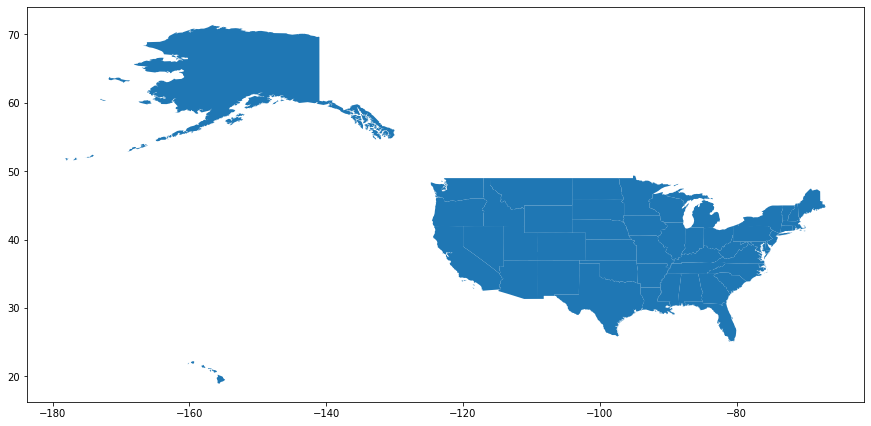

In [ ]:
fig,ax = plt.subplots(figsize=(15,15))
us_map.plot(ax=ax)
#Here's the great nation of the US of America! y alaska so big tho

In [ ]:
# We are going to create a GeoDataFrame, which will store coordinate Points
# to plot these onto our shp file
geo_df = gpd.GeoDataFrame(accidents_df, geometry=gpd.points_from_xy(accidents_df.Start_Lng, accidents_df.Start_Lat))

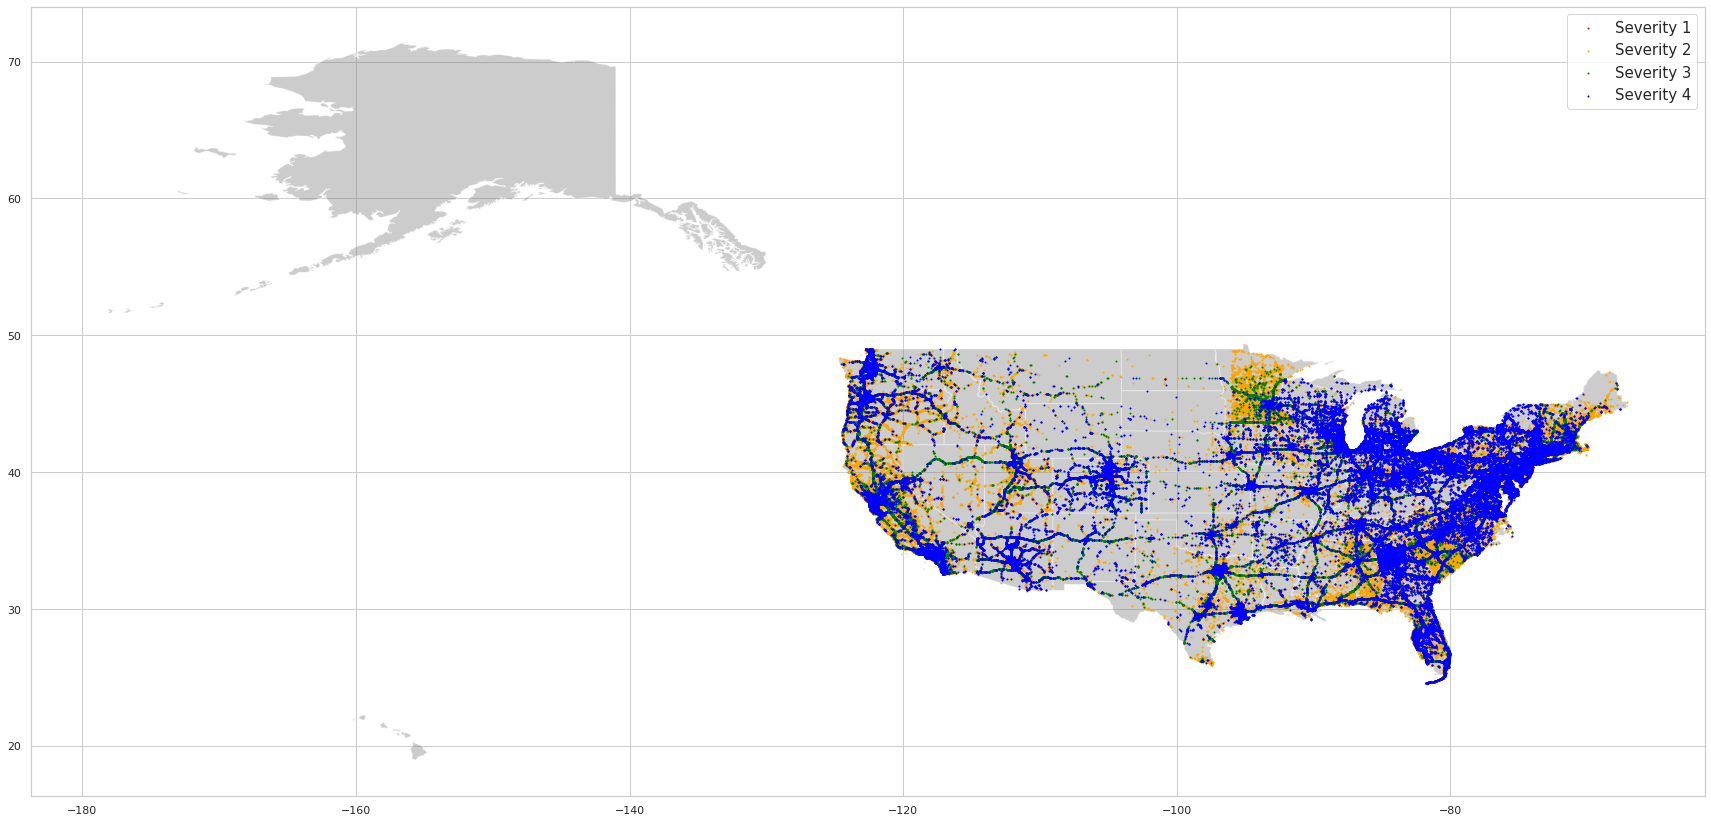

In [ ]:
fig,ax = plt.subplots(figsize=(30,30))
us_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df[geo_df['Severity'] == 1].plot(ax=ax, markersize=1, color='red', marker='o', label='Severity 1', vmin=-130)
geo_df[geo_df['Severity'] == 2].plot(ax=ax, markersize=1, color='orange', marker='o', label='Severity 2')
geo_df[geo_df['Severity'] == 3].plot(ax=ax, markersize=1, color='green', marker='o', label='Severity 3')
geo_df[geo_df['Severity'] == 4].plot(ax=ax, markersize=1, color='blue', marker='o', label='Severity 4')
plt.legend(prop={'size':15})

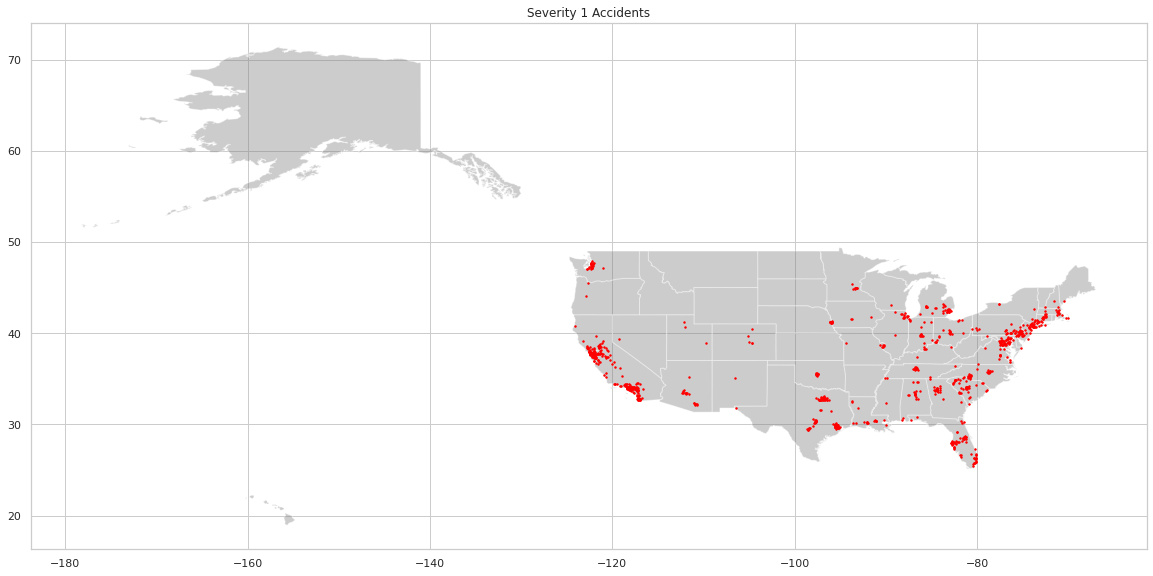

In [ ]:
fig,ax = plt.subplots(figsize=(20,20))
us_map.plot(ax=ax, alpha=0.4, color='grey')
plt.title('Severity 1 Accidents')
geo_df[geo_df['Severity'] == 1].plot(ax=ax, markersize=2, color='red', marker='o', label='Severity 1')

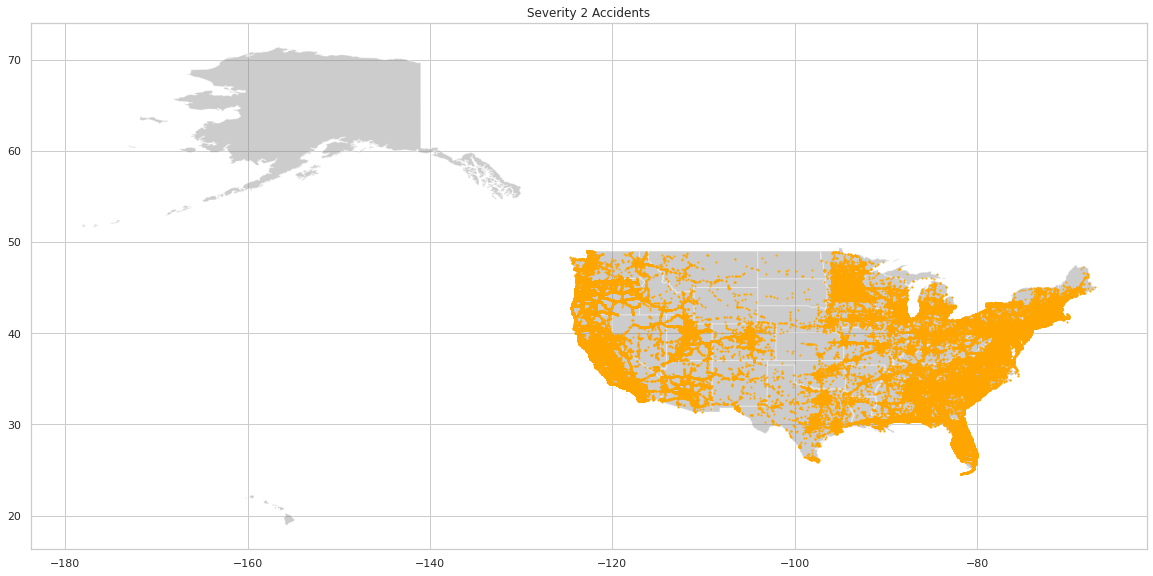

In [ ]:
fig,ax = plt.subplots(figsize=(20,20))
us_map.plot(ax=ax, alpha=0.4, color='grey')
plt.title('Severity 2 Accidents')
geo_df[geo_df['Severity'] == 2].plot(ax=ax, markersize=1, color='orange', marker='o', label='Severity 2')

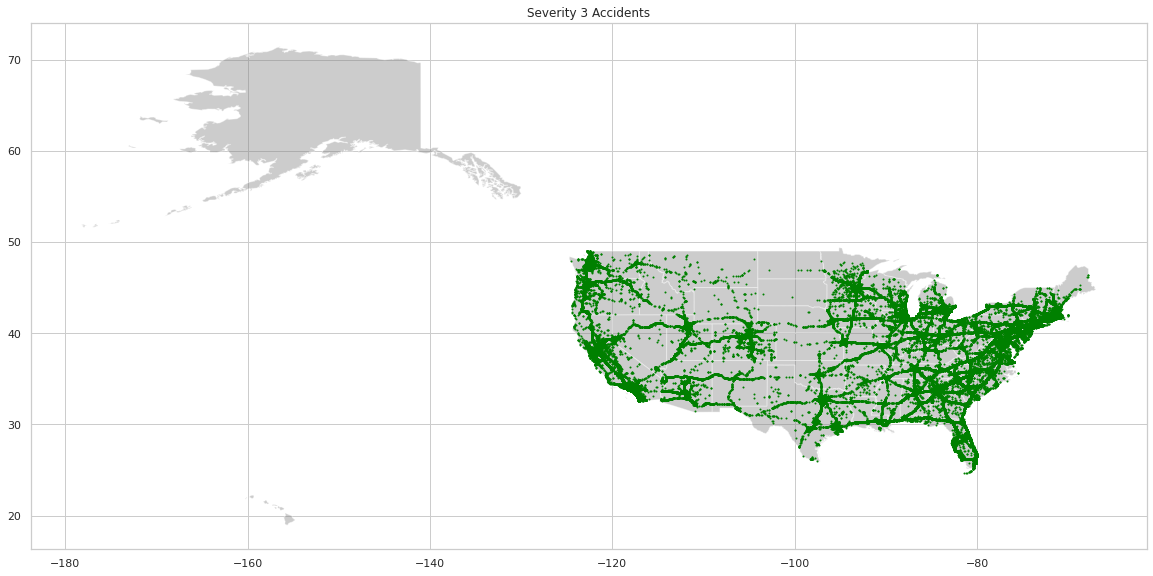

In [ ]:
fig,ax = plt.subplots(figsize=(20,20))
us_map.plot(ax=ax, alpha=0.4, color='grey')
plt.title('Severity 3 Accidents')
geo_df[geo_df['Severity'] == 3].plot(ax=ax, markersize=1, color='green', marker='o', label='Severity 3')

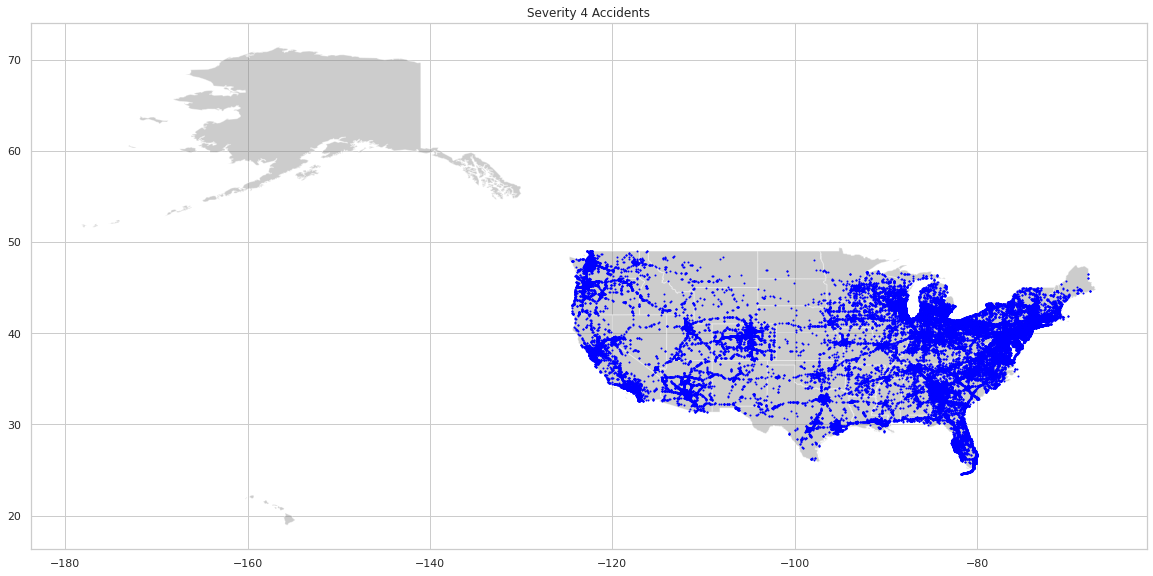

In [ ]:
fig,ax = plt.subplots(figsize=(20,20))
us_map.plot(ax=ax, alpha=0.4, color='grey')
plt.title('Severity 4 Accidents')
geo_df[geo_df['Severity'] == 4].plot(ax=ax, markersize=1, color='blue', marker='o', label='Severity 4', )

For accidents of severity 3 and 4, it clearly delineates major highways in the southwest or so (it's clearest with severity 3).

# 3) Modeling
Here, I am going to try and predict how long an accident lasts, using information an emergency response or dispatch team would (or could) know at the very beginning. To do this, we first need to calculate the time elapsed (in hours) from the start to end of each accident.

In [ ]:
# Extract the end hour for each accident
# example string: 2016-02-08 11:00:00
accidents_df['End_Time'] = accidents_df['End_Time'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
accidents_df['elapsed_time'] = accidents_df['End_Time'] - accidents_df['Start_Time']
accidents_df['elapsed_time'] = accidents_df['elapsed_time'].apply(lambda x: x.total_seconds() / 3600)

Ok, so I made a new field, and since we're trying to predict it let's make sure that it has a sorta normal, even distribution. Sorta.

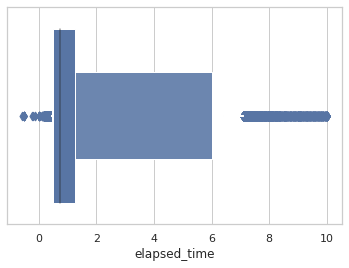

In [ ]:
sns.boxenplot(x='elapsed_time', data=accidents_df[accidents_df['elapsed_time'] <= 10])

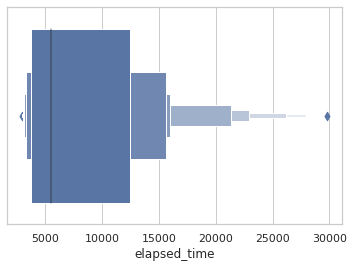

In [ ]:
sns.boxenplot(x='elapsed_time', data=accidents_df[accidents_df['elapsed_time'] >= 3000])

From above, we see that it has a really weird distribution, with a lot of very long lasting accidents. We see that the vast majority of accidents are cleared within a few hours, but some have extremely long times. So we need to convert this to a log scale to better predict it.


In [ ]:
# I was getting a domain error when using the log function, so somehow there
# were negative log times, so I filtered those out.
accidents_df = accidents_df[accidents_df['elapsed_time'] >= 0]

In [ ]:
import math
accidents_df['elapsed_time_log'] = accidents_df['elapsed_time'].apply(lambda x: math.log(x))

Now that we've introduced a new column and we are trying to predict this, let's look at the distribution of elapsed_time_log.



In [ ]:
print('minimum elapsed_time_log = ' + str(accidents_df['elapsed_time_log'].min()))
print('maximum elapsed_time_log = ' + str(accidents_df['elapsed_time_log'].max()))

minimum elapsed_time_log = -3.8982296832958103
maximum elapsed_time_log = 10.301323633479802


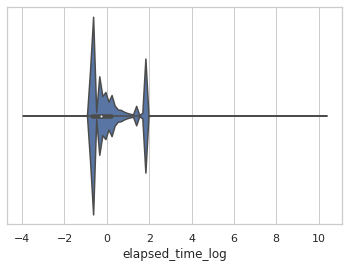

In [ ]:
sns.violinplot(x='elapsed_time_log', data=accidents_df)

That's better than it was before! Which values have a lot of NaN's?

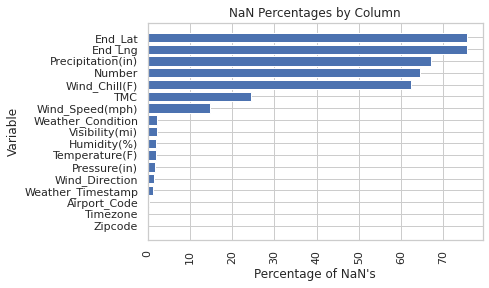

In [ ]:
import numpy as np
na_percentages = []
lam = lambda x: np.round(100*accidents_df[[x]].isnull().sum().sum()/len(accidents_df),2)

for col in list(accidents_df):
    na_percentages.append(lam(col))

#First, let's create a data frame with the new percentages
plotdata = pd.DataFrame({'Variable': list(accidents_df),
                        'NaN Percentage': na_percentages})

#We get rid of the variables that have no NaN's
plotdata = plotdata[
                    plotdata['NaN Percentage'] > 0.00].sort_values(
                        'NaN Percentage',
                         ascending = True).reset_index(drop = True)

#now plot
plt.barh(plotdata['Variable'], plotdata['NaN Percentage'])
plt.title('NaN Percentages by Column') #title
plt.xlabel("Percentage of NaN's") #xaxis label
plt.ylabel('Variable') #yaxis label
plt.xticks(rotation = 90) #rotate ticks so they're legible
plt.show()

Let's drop those columns up until Weather_Condition, and also get rid of source and ID, since they shouldn't have any predictive value. After that, we will get rid of any rows that don't have any field by calling dropna().

In [ ]:
accidents_df = accidents_df.drop(labels=['ID', 'Source', 'End_Lat', 'End_Lng', 'Precipitation(in)', 'Number', 'Wind_Chill(F)', 'TMC', 'Wind_Speed(mph)'], axis=1)
accidents_df = accidents_df.dropna()

We need to convert everything to numerical data, and scale the data as and when needed. What happens to each column?

*   Severity - We want to keep this. Severity is likely a good predictor.
*   Start_Time/End Time - We cannot give it any times, except the start hour and month.
*   Start_Lng/Start_Lat - keep
*   Distance - keep
*   Description - throw away
*   City,County,State,Zipcode,Country,Timezone,Airport_Code - throw away
*   Weather_Timestamp,  - throw this away
*   Amenity	Bump	Crossing	Give_Way	Junction - one hot encode this
*   No_Exit	Railway	Roundabout	Station	Stop	Traffic_Calming	Traffic_Signal	Turning_Loop - one hot encode these
*   Sunrise_Sunset	Civil_Twilight	Nautical_Twilight	Astronomical_Twilight - throw away
*   geometry - throw away
*   elapsed_time - throw away




In [ ]:
accidents_numerical = accidents_df.drop(labels=['Start_Time', 'End_Time', 'Description',
                                                'Street', 'City', 'Country', 'County', 'State', 'Zipcode',
                                                'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
                                                'Wind_Direction', 'Sunrise_Sunset', 'Civil_Twilight',	'Nautical_Twilight',
                                                'Astronomical_Twilight', 'geometry', 'elapsed_time', 'Weather_Condition', 'Side'], axis=1)
accidents_numerical

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,start_hour,start_month,elapsed_time_log
0,3,39.865147,-84.058723,0.010,36.9,91.0,29.68,10.0,False,False,False,False,False,False,False,False,False,False,False,False,False,5,2,1.655048
1,2,39.928059,-82.831184,0.010,37.9,100.0,29.65,10.0,False,False,False,False,False,False,False,False,False,False,False,False,False,6,2,-0.693147
2,2,39.063148,-84.032608,0.010,36.0,100.0,29.67,10.0,False,False,False,False,False,False,False,False,False,False,False,True,False,6,2,-0.693147
3,3,39.747753,-84.205582,0.010,35.1,96.0,29.64,9.0,False,False,False,False,False,False,False,False,False,False,False,False,False,7,2,-0.693147
4,2,39.627781,-84.188354,0.010,36.0,89.0,29.65,6.0,False,False,False,False,False,False,False,False,False,False,False,True,False,7,2,-0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2974330,2,34.002480,-117.379360,0.543,86.0,40.0,28.92,10.0,False,False,False,False,False,False,False,False,False,False,False,False,False,18,8,-0.740938
2974331,2,32.766960,-117.148060,0.338,70.0,73.0,29.39,10.0,False,False,False,False,False,False,False,False,False,False,False,False,False,19,8,-0.802838
2974332,2,33.775450,-117.847790,0.561,73.0,64.0,29.74,10.0,False,False,False,False,True,False,False,False,False,False,False,False,False,19,8,-0.745611
2974333,2,33.992460,-118.403020,0.772,71.0,81.0,29.62,10.0,False,False,False,False,False,False,False,False,False,False,False,False,False,19,8,-0.715052


In [ ]:
# Here, we will convert the boolean values to 0s and 1s
list_of_columns = 'Amenity	Bump	Crossing	Give_Way	Junction	No_Exit	Railway	Roundabout	Station	Stop	Traffic_Calming	Traffic_Signal	Turning_Loop'.split('\t')
for col in list_of_columns:
  accidents_numerical[col] = accidents_numerical[col].astype(int)
accidents_numerical

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,start_hour,start_month,elapsed_time_log
0,3,39.865147,-84.058723,0.010,36.9,91.0,29.68,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,2,1.655048
1,2,39.928059,-82.831184,0.010,37.9,100.0,29.65,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2,-0.693147
2,2,39.063148,-84.032608,0.010,36.0,100.0,29.67,10.0,0,0,0,0,0,0,0,0,0,0,0,1,0,6,2,-0.693147
3,3,39.747753,-84.205582,0.010,35.1,96.0,29.64,9.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,2,-0.693147
4,2,39.627781,-84.188354,0.010,36.0,89.0,29.65,6.0,0,0,0,0,0,0,0,0,0,0,0,1,0,7,2,-0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2974330,2,34.002480,-117.379360,0.543,86.0,40.0,28.92,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,8,-0.740938
2974331,2,32.766960,-117.148060,0.338,70.0,73.0,29.39,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,8,-0.802838
2974332,2,33.775450,-117.847790,0.561,73.0,64.0,29.74,10.0,0,0,0,0,1,0,0,0,0,0,0,0,0,19,8,-0.745611
2974333,2,33.992460,-118.403020,0.772,71.0,81.0,29.62,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,8,-0.715052


**Training a Linear Regression Model** - We finally get to predict some stuff! Let's start off with a basic linear regression model.

In [ ]:
#Let's define our train/test split so we can use this for our algorithms.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(accidents_numerical.drop('elapsed_time_log', axis=1),
                                         accidents_numerical['elapsed_time_log'],
                                         test_size=0.25)

In [ ]:
x_train

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,start_hour,start_month
1941650,3,32.919575,-96.418274,0.000,48.6,35.0,30.34,10.0,0,0,0,0,0,0,0,0,0,0,0,1,0,16,12
2370968,3,34.119680,-117.811360,0.492,46.4,100.0,30.12,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,11
1048585,2,30.153570,-91.960648,0.000,62.1,90.0,30.19,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,3
2220316,2,41.241386,-95.933311,0.000,84.9,43.0,29.89,10.0,0,0,0,0,0,0,0,0,1,0,0,0,0,14,8
969650,2,34.898788,-82.193970,0.000,66.0,84.0,29.27,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1076503,2,35.178280,-106.622437,0.000,73.4,11.0,30.06,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,3
33977,3,37.824085,-122.267754,0.010,57.0,87.0,29.90,9.0,0,0,0,0,1,0,0,0,0,0,0,0,0,8,4
18261,2,38.007011,-122.541573,0.010,51.8,82.0,30.16,10.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,11
1066320,2,32.718250,-117.093430,0.000,59.0,83.0,30.13,10.0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,3


In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
from sklearn import metrics
y_pred = reg.predict(x_test)
print('Coefficients: \n', reg.coef_)
mse = metrics.mean_squared_error(y_test, y_pred)
print('Mean squared error: ' + str(mse))

Coefficients: 
 [-5.04179531e-02  5.47626259e-02  8.17586842e-04 -1.07430136e-03
 -6.75959575e-02  9.21216935e-04 -3.78382005e-02 -8.93078659e-02
 -5.11545540e-02 -1.52837462e-02  3.50947680e-01 -2.48805194e-02
  3.63958330e-02 -5.46784707e-01 -2.50809281e-02 -1.56871842e-01
 -4.05084064e-02 -1.33259896e-01  5.55111512e-17 -6.26614054e-05
 -4.28734921e-03]
Mean squared error: 0.7146797013746048


10^0.71 is roughly 5, so for millions of lines that's not bad at all! Let's try to remove the start latitude and longitude, and try again.

In [ ]:
accidents_numerical = accidents_numerical.drop(['Start_Lat', 'Start_Lng'], axis=1)

In [ ]:
reg = linear_model.LinearRegression()
reg.fit(x_test, y_test)
y_pred = reg.predict(x_train)
print('Coefficients: \n', reg.coef_)
mse = metrics.mean_squared_error(y_train, y_pred)
print('Mean squared error: ' + str(mse))

Coefficients: 
 [-5.02883868e-02  5.74876304e-02  7.13547531e-04 -1.06913140e-03
 -6.82496638e-02  1.49960375e-03 -2.95957539e-02 -1.17621140e-02
 -4.83993788e-02 -8.75977686e-03  3.55615380e-01 -3.20250894e-02
  3.11273852e-02 -5.34652095e-01 -2.83458470e-02 -1.68125011e-01
 -1.06260561e-01 -1.32573418e-01 -2.22044605e-16 -4.85456036e-05
 -4.47951028e-03]
Mean squared error: 0.7155921241269642


That didn't really help alone... Now, we try to use the Lasso Regression.

In [ ]:
lasso_reg = linear_model.Lasso(alpha=0.1)
lasso_reg.fit(x_train, y_train)
y_pred = lasso_reg.predict(x_test)
print('Lasso Coefficients: \n', lasso_reg.coef_)
mse = metrics.mean_squared_error(y_test, y_pred)
print('Lasso Mean squared error: ' + str(mse))

Lasso Coefficients: 
 [-0.          0.01563912  0.00030692 -0.00119753 -0.          0.
 -0.         -0.         -0.         -0.          0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
  0.          0.         -0.        ]
Lasso Mean squared error: 0.7355648648906942


Let's see how Bayesian Regression works.

In [ ]:
from sklearn import linear_model
bayes = linear_model.BayesianRidge()
bayes.fit(x_train, y_train)
y_pred = bayes.predict(x_test)
print('Bayes Coefficients: \n', bayes.coef_)
mse = metrics.mean_squared_error(y_test, y_pred)
print('Bayes Mean squared error: ' + str(mse))

Bayes Coefficients: 
 [-5.01754092e-02  1.57128005e-02 -1.66989412e-03  5.19720419e-02
  2.72040436e-03 -5.43406141e-04 -5.27845979e-02  1.41236562e-03
 -7.32936533e-02 -9.33028167e-02 -5.88662669e-02 -5.98636162e-03
  3.41968310e-01 -3.05180318e-02  2.83463232e-02 -3.32497634e-01
 -3.57204195e-02 -1.65867209e-01 -1.10524886e-01 -1.08745513e-01
 -2.23597081e-16 -6.09413808e-04 -5.43763913e-03]
Bayes Mean squared error: 0.7110336532919634


Now, we try to use PCA to filter out some of the noise.

In [ ]:
import sklearn.decomposition as decomp
pca = decomp.PCA()
pca.fit(accidents_numerical)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca.explained_variance_

array([6.11790960e+02, 2.94819096e+02, 2.58963952e+02, 2.33641194e+01,
       1.91989528e+01, 1.16268924e+01, 7.00452909e+00, 2.35797022e+00,
       7.24433352e-01, 4.88107660e-01, 2.95783976e-01, 1.45050015e-01,
       7.02246257e-02, 4.76465321e-02, 1.89993656e-02, 1.30459776e-02,
       1.06460454e-02, 7.51251527e-03, 2.46349064e-03, 1.15070176e-03,
       4.54646004e-04, 7.53962228e-05, 5.65325669e-05, 1.09488904e-36])

Looks like the first 8 components explains almost all of the variance.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(accidents_numerical.drop('elapsed_time_log', axis=1), accidents_numerical['elapsed_time_log'], test_size=0.25, random_state=42)

pca = decomp.PCA(n_components=8)
reg_pca = linear_model.LinearRegression()
reg_pca.fit(pca.fit_transform(x_train), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred = reg_pca.predict(pca.fit_transform(x_test))
print('Coefficients: \n', reg_pca.coef_)
mse = metrics.mean_squared_error(y_test, y_pred)
print('Mean squared error: %.2f' % mse)

Coefficients: 
 [ 0.00156608 -0.00175855  0.0012401  -0.00494526  0.01751506 -0.00707259
  0.00105272  0.05642382]
Mean squared error: 0.73


We still aren't getting much improvement. Let's try a new model.

Decision Tree

In [ ]:
from sklearn import tree
tree = tree.DecisionTreeRegressor(max_features=8)
tree = tree.fit(x_train, y_train)

In [ ]:
from sklearn import metrics
y_pred = tree.predict(x_test)
print('Coefficients: \n', tree.feature_importances_)
mse = metrics.mean_squared_error(y_test, y_pred)
print('Mean squared error: %.2f' % mse)

Coefficients: 
 [2.75298338e-02 1.12684512e-01 1.19797082e-01 3.37669226e-01
 7.74093194e-02 6.60604433e-02 1.15551199e-01 1.70226248e-02
 1.05211597e-03 9.47342188e-06 3.32526553e-03 2.89646816e-04
 5.74656432e-03 2.01083850e-04 7.67273950e-04 2.20885785e-06
 1.45412912e-03 1.16485989e-03 4.65987621e-05 6.79359981e-03
 0.00000000e+00 5.64904541e-02 4.89324861e-02]
Mean squared error: 0.62


We did better! It looks like setting max_features to 8 gets the lowest MSE. The decision tree can do better than a linear regression model.

In [ ]:
# https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
# I used the above tutorial to see what the decision tree is doing.
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# 4) Description of Challenges/ Obstacles Faced

Deciding which data to eliminate was difficult. It is very unclear which features to use. It also seems that the description or street name could contribute potentially useful information, but it is very difficult to encode in this useful numerical information. This process of feature extraction was helped a bit by the PCA analysis to determine how well components explained the variance, but I am worried that much useful data was eliminated from the data well before this step.

It was also interesting how well the linear regression worked. It was really difficult to bring the MSE down from 0.72. I had to switch to a new model to do this.



# 5) Potential Next Steps/ Future Direction

I think that NLP techniques could be applied to the description to extract useful information from it. In addition, I would want to explore ways to determine if the street was a highway or not, and then one hot encode this information. It seems plausible that severe accidents happen more often on highways and freeways due to the high speed limits.

Ultimately, the most exciting path forward is compare these drives to regular drives. A system that could predict where accidents would happen would be immensely useful to local and state authorities. They can then plan resources and address bottlenecks and be better prepared for emergencies. We would need a control group to predict the frequencies or likelihoods of accidents. This data certainly exists, as GPS apps like Waze are constantly collecting information on people's drives and tracking where they go. By matching these drives with records of accidents, we can develop a powerful system for predicting the likelihood and severity of accidents.